<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 6, '日付': '2021-11-22T08:00:00.000Z'},
 {'小計': 17, '日付': '2021-11-23T08:00:00.000Z'},
 {'小計': 5, '日付': '2021-11-24T08:00:00.000Z'},
 {'小計': 27, '日付': '2021-11-25T08:00:00.000Z'},
 {'小計': 19, '日付': '2021-11-26T08:00:00.000Z'},
 {'小計': 16, '日付': '2021-11-27T08:00:00.000Z'},
 {'小計': 9, '日付': '2021-11-28T08:00:00.000Z'},
 {'小計': 8, '日付': '2021-11-29T08:00:00.000Z'},
 {'小計': 21, '日付': '2021-11-30T08:00:00.000Z'},
 {'小計': 21, '日付': '2021-12-01T08:00:00.000Z'},
 {'小計': 11, '日付': '2021-12-02T08:00:00.000Z'},
 {'小計': 14, '日付': '2021-12-03T08:00:00.000Z'},
 {'小計': 19, '日付': '2021-12-04T08:00:00.000Z'},
 {'小計': 20, '日付': '2021-12-05T08:00:00.000Z'},
 {'小計': 7, '日付': '2021-12-06T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-12-02 17:00:00+09:00,97,0,11,2021-12-02 17:00:00+09:00
2021-12-03 17:00:00+09:00,100,0,14,2021-12-03 17:00:00+09:00
2021-12-04 17:00:00+09:00,81,0,19,2021-12-04 17:00:00+09:00
2021-12-05 17:00:00+09:00,40,0,20,2021-12-05 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-12-02 17:00:00+09:00,97,0,11,2021-12-02 17:00:00+09:00,78.714286,551.0,0.0,0.0,15.000000,105.0
2021-12-03 17:00:00+09:00,100,0,14,2021-12-03 17:00:00+09:00,83.857143,587.0,0.0,0.0,14.285714,100.0
2021-12-04 17:00:00+09:00,81,0,19,2021-12-04 17:00:00+09:00,87.285714,611.0,0.0,0.0,14.714286,103.0
2021-12-05 17:00:00+09:00,40,0,20,2021-12-05 17:00:00+09:00,87.142857,610.0,0.0,0.0,16.285714,114.0
2021-12-06 17:00:00+09:00,0,0,7,2021-12-06 17:00:00+09:00,74.142857,519.0,0.0,0.0,16.142857,113.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-11-22 17:00:00+09:00,65,0,6,2021-11-22 17:00:00+09:00,71.142857,498.0,0.0,0.0,17.142857,120.0,'21w47,Mon
2021-11-23 17:00:00+09:00,70,0,17,2021-11-23 17:00:00+09:00,67.142857,470.0,0.0,0.0,17.428571,122.0,'21w47,Tue
2021-11-24 17:00:00+09:00,87,0,5,2021-11-24 17:00:00+09:00,68.285714,478.0,0.0,0.0,14.285714,100.0,'21w47,Wed
2021-11-25 17:00:00+09:00,62,0,27,2021-11-25 17:00:00+09:00,68.000000,476.0,0.0,0.0,15.285714,107.0,'21w47,Thu
2021-11-26 17:00:00+09:00,64,0,19,2021-11-26 17:00:00+09:00,65.000000,455.0,0.0,0.0,15.714286,110.0,'21w47,Fri
2021-11-27 17:00:00+09:00,57,0,16,2021-11-27 17:00:00+09:00,65.714286,460.0,0.0,0.0,15.714286,110.0,'21w47,Sat
2021-11-28 17:00:00+09:00,41,0,9,2021-11-28 17:00:00+09:00,63.714286,446.0,0.0,0.0,14.142857,99.0,'21w47,Sun
2021-11-29 17:00:00+09:00,91,0,8,2021-11-29 17:00:00+09:00,67.428571,472.0,0.0,0.0,14.428571,101.0,'21w48,Mon
2021-11-30 17:00:00+09:00,103,0,21,2021-11-30 17:00:00+09:00,72.142857,505.0,0.0,0.0,15.000000,105.0,'21w48,Tue
2021-12-01 17:00:00+09:00,98,0,21,2021-12-01 17:00:00+09:00,73.714286,516.0,0.0,0.0,17.285714,121.0,'21w48,Wed


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-11-21 17:00:00+09:00,17.285714,121
2021-11-28 17:00:00+09:00,14.142857,99
2021-12-05 17:00:00+09:00,16.285714,114
2021-12-06 17:00:00+09:00,7.000000,7
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-11-22 17:00:00+09:00,65,0,6,2021-11-22 17:00:00+09:00,71.142857,498.0,0.0,0.0,17.142857,120.0,'21w47,Mon,NaN,NaN
2021-11-23 17:00:00+09:00,70,0,17,2021-11-23 17:00:00+09:00,67.142857,470.0,0.0,0.0,17.428571,122.0,'21w47,Tue,NaN,NaN
2021-11-24 17:00:00+09:00,87,0,5,2021-11-24 17:00:00+09:00,68.285714,478.0,0.0,0.0,14.285714,100.0,'21w47,Wed,NaN,NaN
2021-11-25 17:00:00+09:00,62,0,27,2021-11-25 17:00:00+09:00,68.000000,476.0,0.0,0.0,15.285714,107.0,'21w47,Thu,NaN,NaN
2021-11-26 17:00:00+09:00,64,0,19,2021-11-26 17:00:00+09:00,65.000000,455.0,0.0,0.0,15.714286,110.0,'21w47,Fri,NaN,NaN
2021-11-27 17:00:00+09:00,57,0,16,2021-11-27 17:00:00+09:00,65.714286,460.0,0.0,0.0,15.714286,110.0,'21w47,Sat,NaN,NaN
2021-11-28 17:00:00+09:00,41,0,9,2021-11-28 17:00:00+09:00,63.714286,446.0,0.0,0.0,14.142857,99.0,'21w47,Sun,14.142857,99.0
2021-11-29 17:00:00+09:00,91,0,8,2021-11-29 17:00:00+09:00,67.428571,472.0,0.0,0.0,14.428571,101.0,'21w48,Mon,NaN,NaN
2021-11-30 17:00:00+09:00,103,0,21,2021-11-30 17:00:00+09:00,72.142857,505.0,0.0,0.0,15.000000,105.0,'21w48,Tue,NaN,NaN
2021-12-01 17:00:00+09:00,98,0,21,2021-12-01 17:00:00+09:00,73.714286,516.0,0.0,0.0,17.285714,121.0,'21w48,Wed,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

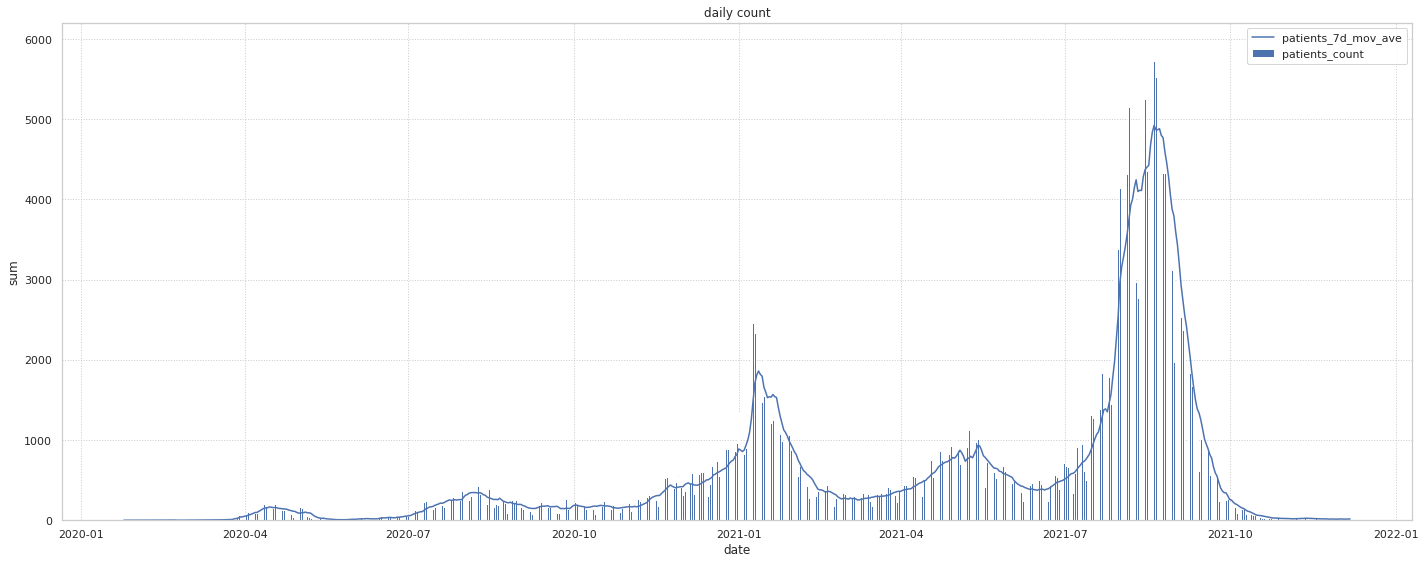

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
668,1.637568e+09,2021,11,22,0,1,0,0,0,0,0,668,0,594,65,71.142857,498.0,0,0.0,0.0,6,17.142857,120.0
669,1.637654e+09,2021,11,23,0,0,0,0,0,1,0,669,0,595,70,67.142857,470.0,0,0.0,0.0,17,17.428571,122.0
670,1.637741e+09,2021,11,24,0,0,0,0,0,0,1,670,0,596,87,68.285714,478.0,0,0.0,0.0,5,14.285714,100.0
671,1.637827e+09,2021,11,25,0,0,0,0,1,0,0,671,0,597,62,68.000000,476.0,0,0.0,0.0,27,15.285714,107.0
672,1.637914e+09,2021,11,26,1,0,0,0,0,0,0,672,0,598,64,65.000000,455.0,0,0.0,0.0,19,15.714286,110.0
673,1.638000e+09,2021,11,27,0,0,1,0,0,0,0,673,0,599,57,65.714286,460.0,0,0.0,0.0,16,15.714286,110.0
674,1.638086e+09,2021,11,28,0,0,0,1,0,0,0,674,0,600,41,63.714286,446.0,0,0.0,0.0,9,14.142857,99.0
675,1.638173e+09,2021,11,29,0,1,0,0,0,0,0,675,0,601,91,67.428571,472.0,0,0.0,0.0,8,14.428571,101.0
676,1.638259e+09,2021,11,30,0,0,0,0,0,1,0,676,0,602,103,72.142857,505.0,0,0.0,0.0,21,15.000000,105.0
677,1.638346e+09,2021,12,1,0,0,0,0,0,0,1,677,0,603,98,73.714286,516.0,0,0.0,0.0,21,17.285714,121.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            683 non-null    float64
 1   year                 683 non-null    int64  
 2   month                683 non-null    int64  
 3   day                  683 non-null    int64  
 4   Fri                  683 non-null    uint8  
 5   Mon                  683 non-null    uint8  
 6   Sat                  683 non-null    uint8  
 7   Sun                  683 non-null    uint8  
 8   Thu                  683 non-null    uint8  
 9   Tue                  683 non-null    uint8  
 10  Wed                  683 non-null    uint8  
 11  passed               683 non-null    int64  
 12  emergency            683 non-null    int64  
 13  em_passed            683 non-null    int64  
 14  contacts_count       683 non-null    int64  
 15  contacts_7d_mov_ave  683 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.609315e+09,2020.497804,6.505124,15.745242,0.143485,0.143485,0.143485,0.143485,0.142020,0.142020,0.142020,341.000000,0.071742,271.062958,635.074671,634.842048,4443.888726,539.559297,539.559297,3776.915081,559.688141,559.628174,3917.373353
std,1.704753e+07,0.500362,3.259710,8.878429,0.350823,0.350823,0.350823,0.350823,0.349327,0.349327,0.349327,197.309402,0.258250,191.153284,474.321150,462.787560,3239.520587,812.968863,743.194873,5202.364111,966.583133,934.428646,6541.014821
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.594584e+09,2020.000000,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,170.500000,0.000000,96.500000,331.000000,335.928571,2351.500000,0.000000,0.000000,0.000000,54.500000,55.642857,389.500000
50%,1.609315e+09,2020.000000,7.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,341.000000,0.000000,267.000000,505.000000,503.285714,3523.000000,0.000000,0.000000,0.000000,243.000000,258.285714,1808.000000
75%,1.624046e+09,2021.000000,9.000000,23.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,511.500000,0.000000,437.500000,776.500000,760.642857,5324.500000,1113.500000,1089.285714,7625.000000,570.000000,580.214286,4061.500000
max,1.638778e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,682.000000,1.000000,608.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,5908.000000,4923.428571,34464.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.866018,0.393578,-0.001007,-0.003114,0.003114,-0.001038,0.001038,0.002064,-0.002064,-2.751714e-18,1.000000e+00,-0.342634,0.998042,-0.268775,-0.255459,-0.255455,-0.612434,-0.658877,-0.658877,0.393408,0.415942,0.415947
year,8.660180e-01,1.000000,-0.116636,-0.029832,0.001798,0.001798,0.001798,0.001798,-0.002407,-0.002407,-2.407326e-03,8.660180e-01,-0.276787,0.872731,-0.242242,-0.225866,-0.225864,-0.661265,-0.723348,-0.723348,0.399162,0.421895,0.421897
month,3.935776e-01,-0.116636,1.000000,-0.036382,-0.009619,0.003203,-0.005773,-0.001926,0.009017,0.000004,5.154451e-03,3.935776e-01,-0.170262,0.377211,-0.086373,-0.090091,-0.090088,0.000229,0.023243,0.023243,0.046522,0.049563,0.049569
day,-1.006926e-03,-0.029832,-0.036382,1.000000,0.001396,-0.003311,0.004221,0.007516,-0.005337,0.003646,-8.173405e-03,-1.006926e-03,-0.001610,-0.000302,-0.007839,-0.008822,-0.008824,0.006578,-0.004824,-0.004824,0.009831,0.006752,0.006748
Fri,-3.113843e-03,0.001798,-0.009619,0.001396,1.000000,-0.167521,-0.167521,-0.167521,-0.166522,-0.166522,-1.665222e-01,-3.113843e-03,-0.000498,-0.002540,-0.015758,-0.002408,-0.002408,0.026863,-0.001300,-0.001300,0.028104,-0.001072,-0.001074
Mon,3.113843e-03,0.001798,0.003203,-0.003311,-0.167521,1.000000,-0.167521,-0.167521,-0.166522,-0.166522,-1.665222e-01,3.113843e-03,-0.000498,0.003167,0.030195,-0.002252,-0.002251,0.109727,-0.001300,-0.001300,-0.090279,-0.001046,-0.001045
Sat,-1.037948e-03,0.001798,-0.005773,0.004221,-0.167521,-0.167521,1.000000,-0.167521,-0.166522,-0.166522,-1.665222e-01,-1.037948e-03,-0.000498,-0.000638,0.041650,-0.002304,-0.002303,-0.129220,-0.001300,-0.001300,0.028809,-0.001061,-0.001062
Sun,1.037948e-03,0.001798,-0.001926,0.007516,-0.167521,-0.167521,-0.167521,1.000000,-0.166522,-0.166522,-1.665222e-01,1.037948e-03,-0.000498,0.001264,-0.025891,-0.002252,-0.002251,-0.119148,-0.001300,-0.001300,-0.023192,-0.001049,-0.001050
Thu,2.063514e-03,-0.002407,0.009017,-0.005337,-0.166522,-0.166522,-0.166522,-0.166522,1.000000,-0.165529,-1.655290e-01,2.063514e-03,0.000666,0.001491,-0.003666,0.003210,0.003210,0.034091,0.001741,0.001741,0.051912,0.001424,0.001426
Tue,-2.063514e-03,-0.002407,0.000004,0.003646,-0.166522,-0.166522,-0.166522,-0.166522,-0.165529,1.000000,-1.655290e-01,-2.063514e-03,0.000666,-0.002330,-0.016763,0.002957,0.002958,0.046033,0.001741,0.001741,-0.017612,0.001404,0.001405


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,1.638432e+09,0,0,0,0,1,0,0,678,0,604,97,0,11,15.000000,105.0
679,1.638518e+09,1,0,0,0,0,0,0,679,0,605,100,0,14,14.285714,100.0
680,1.638605e+09,0,0,1,0,0,0,0,680,0,606,81,0,19,14.714286,103.0
681,1.638691e+09,0,0,0,1,0,0,0,681,0,607,40,0,20,16.285714,114.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
678,1.638432e+09,678,0,11,15.000000,105.0
679,1.638518e+09,679,0,14,14.285714,100.0
680,1.638605e+09,680,0,19,14.714286,103.0
681,1.638691e+09,681,0,20,16.285714,114.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

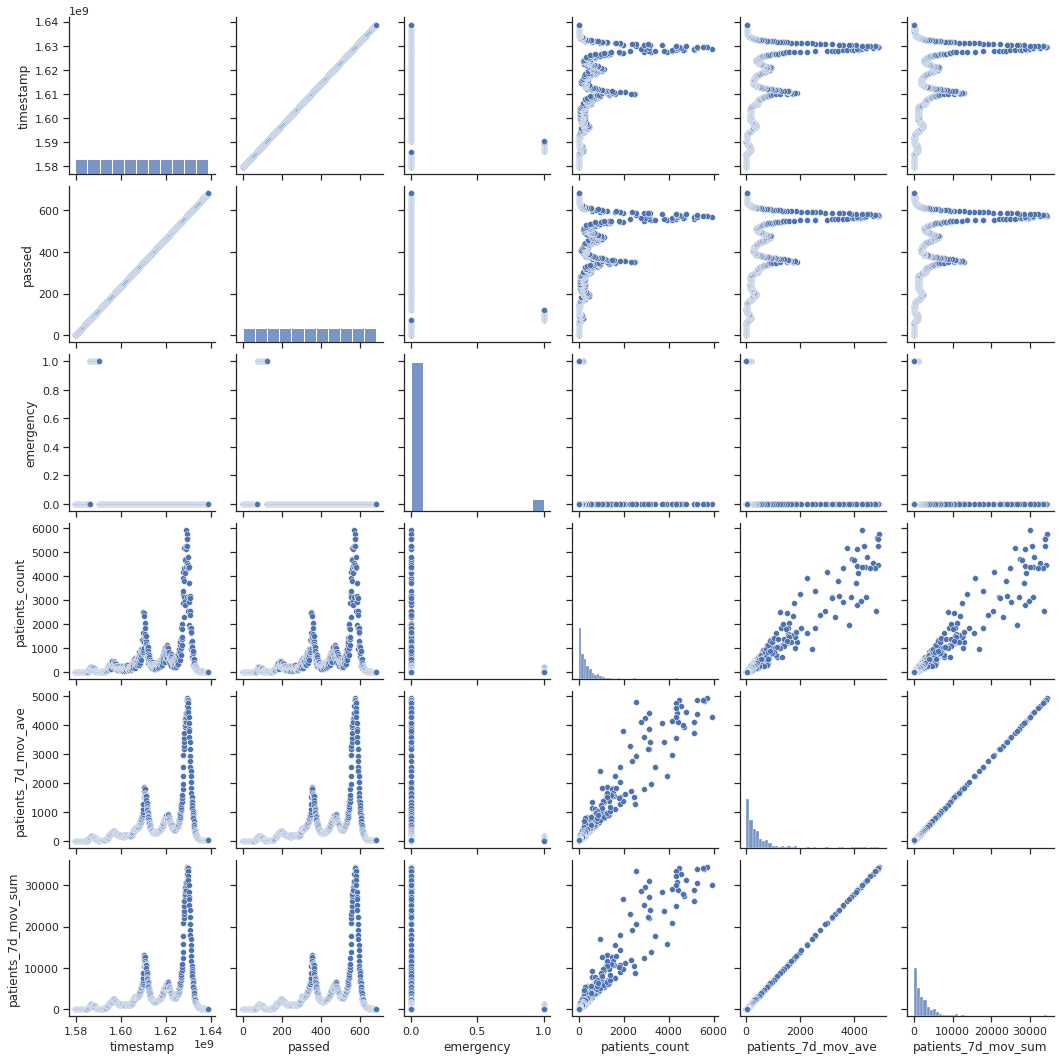

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12
